# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-S109A Introduction to Data Science 

## Homework 3:  Regularization, Cross-Validation, and Logistic Regression 

**Harvard University**<br/>
**Summer 2020**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import warnings
warnings.filterwarnings('ignore')

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [4]:
######
# your code here
######
bikes_df_raw = pd.read_csv("data/BSS_hour_raw.csv")
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [5]:
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [6]:
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

The dtypes of the variables `season`, `hour`, `holiday`, `weekday`, `workingday`, and `weather`are not appropriate because these variables are categorical. However, not all of these categorical data types are the same. In particular, `weather` can be treated as an ordered categorical data type that represents the severity of the weather. 

**1.2 Notice that the variable in column...**

In [7]:
######
# your code here
######

bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw['dteday'], format='%Y/%m/%d')

In [8]:
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [9]:
bikes_df_raw.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

**1.3 Create three new columns in the dataframe:...**

In [10]:
######
# your code here
######
year = [bikes_df_raw.dteday[i].year for i in range(bikes_df_raw.shape[0])]
bikes_df_raw["year"] = year

month = [bikes_df_raw.dteday[i].month for i in range(bikes_df_raw.shape[0])]
bikes_df_raw["month"] = month

counts = bikes_df_raw.casual + bikes_df_raw.registered
bikes_df_raw["counts"] = counts

In [11]:
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,2011,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,2011,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,2011,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,2011,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,2011,1,1


---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` (please use the copy provided to you in `data/bikes_by_day.csv` for consistency and easy checking) to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather')  in the original hourly dataset into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 


### Answers

**2.1 Make a new dataframe...**

In [12]:
bikes_by_day = bikes_df_raw.groupby('dteday').agg({
    'weekday': np.median,
    'weather': np.max,
    'season': np.median,
    'temp': np.mean,
    'atemp': np.mean,
    'windspeed': np.mean,
    'hum': np.mean,
    'casual': np.sum,
    'registered': np.sum,
    'counts': np.sum
})

bikes_by_day.reset_index(inplace=True)
bikes_by_day['dteday'] = pd.to_datetime(bikes_by_day['dteday'], format='%Y/%m/%d')
bikes_by_day.head()

,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
0,2011-01-01,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
1,2011-01-02,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2,2011-01-03,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
3,2011-01-04,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
4,2011-01-05,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


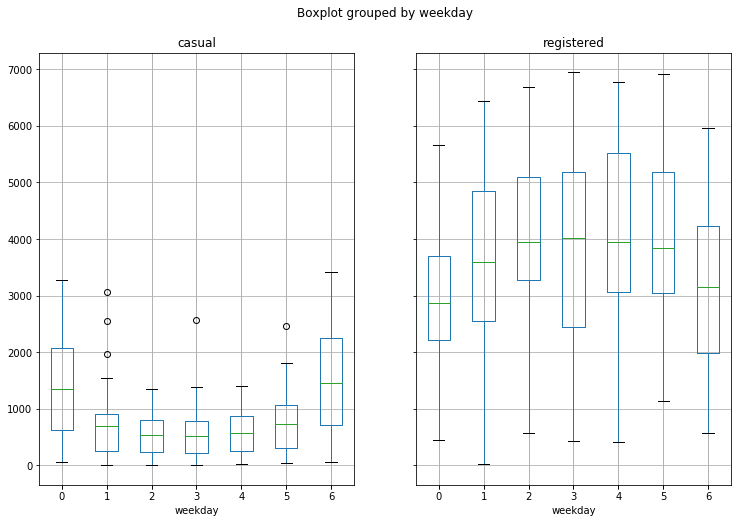

In [13]:
boxplot = bikes_by_day.boxplot(column=['casual', 'registered'], by='weekday', figsize = (12,8))

**2.2 Use `bikes_by_day` to visualize how the distribution...**

In [14]:
bikes_by_day = pd.read_csv("data/bikes_by_day.csv")
bikes_by_day.head()

,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
0,2011-01-01,985,331,3,654,1,6,0.160446,0.344167,0.363625,0.805833
1,2011-01-02,801,131,3,670,1,0,0.248539,0.363478,0.353739,0.696087
2,2011-01-03,1349,120,1,1229,1,1,0.248309,0.196364,0.189405,0.437273
3,2011-01-04,1562,108,2,1454,1,2,0.160296,0.200000,0.212122,0.590435
4,2011-01-05,1600,82,1,1518,1,3,0.186900,0.226957,0.229270,0.436957


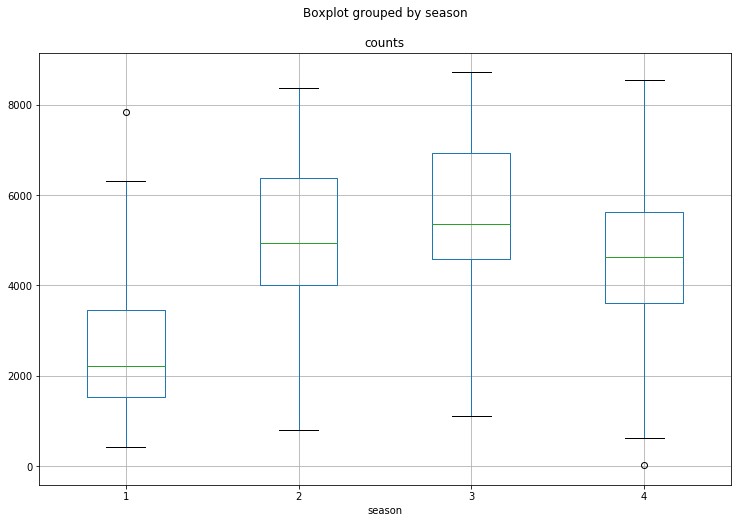

In [15]:
# plotting season against rentals

boxplot = bikes_by_day.boxplot(column=['counts'], by='season', figsize = (12,8))

In [16]:
#outlier 1 fors season 1
max_count = max(bikes_by_day[bikes_by_day.season == 1].counts.values)
bikes_by_day[(bikes_by_day.counts == max_count) & (bikes_by_day.season==1)]

,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
441,2012-03-17,7836,3155,2,4681,1,6,0.110704,0.514167,0.505046,0.755833


In [17]:
bikes_by_day[(bikes_by_day.temp > 0.5) & (bikes_by_day.season==1)].counts.describe()

count       9.000000
mean     5553.444444
std      1549.767653
min      2927.000000
25%      5382.000000
50%      6093.000000
75%      6192.000000
max      7836.000000
Name: counts, dtype: float64

In [18]:
#outlier 1 for season 4
min_count = min(bikes_by_day[bikes_by_day.season == 4].counts.values)
bikes_by_day[(bikes_by_day.counts == min_count) & (bikes_by_day.season == 4)]

,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
667,2012-10-29,22,2,3,20,4,1,0.3582,0.44,0.4394,0.88


In [19]:
bikes_by_day[(bikes_by_day.season == 4) & (bikes_by_day.dteday > '2012-10-25')].head(8)

,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
664,2012-10-26,7444,1182,2,6262,4,5,0.132467,0.545833,0.522750,0.807083
665,2012-10-27,7852,2643,2,5209,4,6,0.235692,0.530000,0.515133,0.720000
666,2012-10-28,4459,998,3,3461,4,0,0.398008,0.477500,0.467771,0.694583
667,2012-10-29,22,2,3,20,4,1,0.358200,0.440000,0.439400,0.880000
668,2012-10-30,1096,87,3,1009,4,2,0.213009,0.318182,0.309909,0.825455
669,2012-10-31,5566,419,2,5147,4,3,0.166667,0.357500,0.361100,0.666667
670,2012-11-01,5986,466,3,5520,4,4,0.157346,0.365833,0.369942,0.581667
671,2012-11-02,5847,618,2,5229,4,5,0.266175,0.355000,0.356042,0.522083


The `whis` variable was set to 1.5 times the IQR past the low and high quartiles to extend the plot whiskers. According to this definition there are two outliers. Namely, there is one outlier above the 1.5 times the IQR above the 75 percentile for season 1 (winter) and another outlier below the 1.5 times the IQR below the 25 percentile range for season 4 (fall). 

The outlier data point for the winter season occurred on 2011-03-17 with a total count of 7836. It was a cloudy day, but with no rain. The temperature was 51 degrees fahrenheit. The data shows that for days in the winter with temperature greater than 50F, the mean number of rentals was 5553, which is much higher than the overall mean for the winter as can be seen in the box plot. Furthermore, March 17 is only 4 days before the cutoff point for the winter, and the subsequent transition into the spring, according to the data. Since there were not particularly significant events on this day, it was probably a chance occurrence. 

The outlier data point for the fall season occurred on 2012-10-29 with a total count of 22. The weather was rainy with a temperature of 44F. On the 27th of October, 2012, the mayor of Washington D.C. called a state of emergency in preparation for Hurricane Sandy. The state of emergency was called off on November 2nd of the same year. As can be seen in the data, as the weather worsens during this period, rental counts drop as well. 

**2.3 Convert the categorical attributes...**

In [20]:
# Since this is supposed to be a train/test set, I have dropped the first group of each categorical variable
    
bikes_df = pd.get_dummies(bikes_df_raw, columns = ['season', 'month', 'weekday', 'weather'], drop_first = True)

bikes_df.head()


,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,13,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0.22,0.2727,0.80,0.0,8,32,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,5,27,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0.24,0.2879,0.75,0.0,3,10,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [21]:
bikes_df.dtypes

dteday        datetime64[ns]
hour                   int64
holiday                int64
workingday             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
year                   int64
counts                 int64
season_2               uint8
season_3               uint8
season_4               uint8
month_2                uint8
month_3                uint8
month_4                uint8
month_5                uint8
month_6                uint8
month_7                uint8
month_8                uint8
month_9                uint8
month_10               uint8
month_11               uint8
month_12               uint8
weekday_1              uint8
weekday_2              uint8
weekday_3              uint8
weekday_4              uint8
weekday_5              uint8
weekday_6              uint8
weather_2              uint8
weather_3              uint8
weather_4     

**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 


In [22]:
#before creating train-test split, make sure dtypes are correct
bikes_train, bikes_test = train_test_split(bikes_df, test_size = 0.5, stratify=bikes_df[['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']], random_state=90)

In [23]:
bikes_train.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
11235,2012-04-18,8,0,1,0.50,0.4848,0.39,0.1940,25,551,...,0,0,0,1,0,0,0,0,1,0
11277,2012-04-20,2,0,1,0.44,0.4394,0.88,0.1940,3,18,...,0,0,0,0,0,1,0,0,0,0
11759,2012-05-10,4,0,1,0.46,0.4545,0.77,0.1940,0,2,...,0,0,0,0,1,0,0,0,0,0
9732,2012-02-15,11,0,1,0.36,0.3333,0.53,0.2836,13,125,...,0,0,0,1,0,0,0,0,0,0
4876,2011-07-27,2,0,1,0.76,0.6970,0.52,0.2985,1,5,...,0,0,0,1,0,0,0,0,0,0


**2.5 Although we asked you to create your train and test set...**

In [24]:
######
# your code here
######

BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')

BSS_train.drop(columns = ['dteday'], inplace = True)
BSS_test.drop(columns = ['dteday'], inplace = True)

In [25]:
BSS_test.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,5,0,1,0,0.26,0.2273,0.48,0.2985,0,2,...,1,0,0,0,0,0,0,1,0,0
1,19,0,1,0,0.36,0.3485,0.71,0.1343,29,110,...,0,0,0,0,0,0,1,0,1,0
2,12,0,1,1,0.36,0.3182,0.53,0.4478,13,213,...,1,0,1,0,0,0,0,1,0,0
3,0,0,1,1,0.28,0.3030,0.65,0.0896,4,39,...,0,0,0,0,0,1,0,1,0,0
4,1,0,1,0,0.60,0.5455,0.88,0.1642,31,99,...,0,0,0,0,0,0,0,1,0,0


In [26]:
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,0.24,0.2273,0.60,0.2537,12,51,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.62,0.5758,0.83,0.2537,47,432,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,0.76,0.7273,0.66,0.1642,54,299,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.62,0.6061,0.22,0.2985,185,226,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,0.18,0.1970,0.40,0.1343,9,61,...,0,0,0,0,0,0,0,0,0,0


**2.6 Make a plot showing the _average_ number of casual and registered riders...**

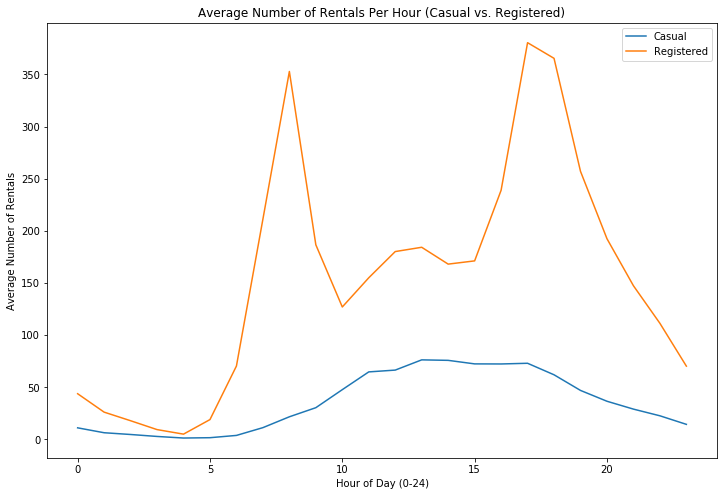

In [27]:
BSS_train_hour = BSS_train.groupby(['hour']).agg({
    'casual': np.mean,
    'registered': np.mean
}).reset_index()

plt.figure(figsize=(12,8))
plt.plot(BSS_train_hour['hour'], BSS_train_hour['casual'], label='Casual')
plt.plot(BSS_train_hour['hour'], BSS_train_hour['registered'], label='Registered')
plt.xlabel('Hour of Day (0-24)')
plt.ylabel('Average Number of Rentals')
plt.title('Average Number of Rentals Per Hour (Casual vs. Registered)')
plt.legend()
plt.show()

For registered users, on average, there is a spike in usage during commuting hours for both morning and night, whereas casual users tend to rent during the afternoons. We saw in previous boxplots that weekdays (Mon-Fri) seem to have higher number of rentals than that of the weekend days for registered users. Therefore, registered users may rely on bike rentals for commute. However, for casual users weekend rentals seem to be more common based on previous box plots. Therefore, casual users may have less need for rental bikes during commuting hours and instead, rent for leisure.  

---

<div class='exercise'> <b> Question 3 [14pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?


### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [28]:
trivial_cols = ['casual','registered']

BSS_train = BSS_train.drop(trivial_cols, axis=1)
BSS_test = BSS_test.drop(trivial_cols, axis=1)

In [29]:
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,0.24,0.2273,0.60,0.2537,63,0,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.62,0.5758,0.83,0.2537,479,0,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,0.76,0.7273,0.66,0.1642,353,0,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.62,0.6061,0.22,0.2985,411,1,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,0.18,0.1970,0.40,0.1343,70,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
BSS_train.describe()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,11.597537,0.029347,0.503395,0.683048,0.496405,0.475399,0.625256,0.190616,190.381517,0.250316,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,6.960206,0.168788,0.500017,0.465316,0.192561,0.171993,0.192281,0.123252,181.432185,0.433220,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,40.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,144.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,0.000000,1.000000,1.000000,0.660000,0.621200,0.780000,0.253700,284.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,23.000000,1.000000,1.000000,1.000000,0.980000,0.984800,1.000000,0.850700,977.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
#since all categorical variables with more than 2 classes have been one-hot encoded, I have not changed the data types
# In python, int and float arithmetic is handled as a float, so I have not converted integer variables to floats
BSS_train.dtypes

hour            int64
holiday         int64
year            int64
workingday      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
counts          int64
spring          int64
summer          int64
fall            int64
Feb             int64
Mar             int64
Apr             int64
May             int64
Jun             int64
Jul             int64
Aug             int64
Sept            int64
Oct             int64
Nov             int64
Dec             int64
Mon             int64
Tue             int64
Wed             int64
Thu             int64
Fri             int64
Sat             int64
Cloudy          int64
Snow            int64
Storm           int64
dtype: object

In [32]:
######
# your code here
######

X_train = BSS_train.drop(columns =['counts'])
X = sm.add_constant(X_train)
model = OLS(BSS_train.counts, X).fit()

print(f'The R-squared score on training set is {round(model.rsquared, 5)}.')


X_test = BSS_test.drop(columns =['counts'])
Xnew = sm.add_constant(X_test)
pred_test = model.predict(Xnew)

print(f'The R-squared score on the test set is {round(r2_score(BSS_test.counts.values, pred_test.values), 5)}.')

The R-squared score on training set is 0.41157.
The R-squared score on the test set is 0.40072.


**3.2 Examine the estimated coefficients and report...**

In [33]:
######
# your code here
######

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:48:24   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

Based on the summary above, `hour`, `year` `workingday`, `temp`, `atemp`, `hum`, `spring`, `summer`, `fall`, `Apr`, `May`, `Jun`, `Jul`, `Aug`, `Nov`, `Dec`, `Sat`, `Cloudy`, `Snow` are statistically significant at significance level of 5%.

**3.3 You should see some strange estimates for the predictors representing months...** 

The coefficients of the predictors representing months are all negative with generally large coefficients (in absolute terms) and standard errors. In particular, the July coefficient is the largest with the highest standard error among the month predictors. Together, this evidence points to multicollinearity between the July predictor and other predictors. As an additional check, it would nice to see if the coefficients change drastically from sample to sample. 

**3.4 To diagnose the model, make two plots:...**



3.4 To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model  𝑒=𝑦−𝑦̂   as a function of the predicted value  𝑦̂  . Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

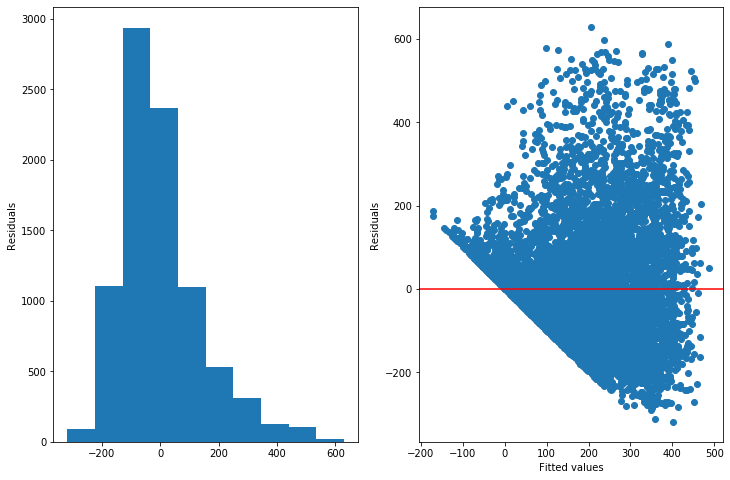

In [34]:
######
# your code here
######

plt.figure(figsize=(12,8))

# model residuals

residual = BSS_train.counts - model.predict(X)
plt.subplot(1, 2, 1)
plt.hist(residual)
plt.ylabel('Residuals')

#fitted values of y
plt.subplot(1,2, 2)
plt.axhline(y=0, color='r')
plt.scatter(model.predict(X), residual)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

plt.show()

By the histogram, we can see that the distribution of the residuals is non-normal due to the right skewness. The scatter plot shows clear evidence of heteroscedasticity since the variance around the horizontal line representing a residual of zero is not constant (fan-like shape). It is a little more difficult to determine if there is non-linearity by the scatter plot alone because of the severe heteroskedasticity. However, it will probably be more clear if we remove some of the correlated predictors. Overall, these plots show that there is some clear violations of OLS assumptions.

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For polynomials of degree 2, 6 and 10:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Which model would you select, and why?

### Answers

**4.1 Drop...**

In [35]:
######
# your code here
######

BSS_train = BSS_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)
BSS_test = BSS_test.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)

In [36]:
BSS_train.shape

(8689, 27)

In [37]:
BSS_train.dtypes

hour           int64
holiday        int64
year           int64
temp         float64
hum          float64
windspeed    float64
counts         int64
Feb            int64
Mar            int64
Apr            int64
May            int64
Jun            int64
Jul            int64
Aug            int64
Sept           int64
Oct            int64
Nov            int64
Dec            int64
Mon            int64
Tue            int64
Wed            int64
Thu            int64
Fri            int64
Sat            int64
Cloudy         int64
Snow           int64
Storm          int64
dtype: object

In [38]:
BSS_test.shape

(8690, 27)

In [39]:
BSS_test.dtypes

hour           int64
holiday        int64
year           int64
temp         float64
hum          float64
windspeed    float64
counts         int64
Feb            int64
Mar            int64
Apr            int64
May            int64
Jun            int64
Jul            int64
Aug            int64
Sept           int64
Oct            int64
Nov            int64
Dec            int64
Mon            int64
Tue            int64
Wed            int64
Thu            int64
Fri            int64
Sat            int64
Cloudy         int64
Snow           int64
Storm          int64
dtype: object

**4.2 Write a function to standardize...**


**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


In [40]:
######
# your code here
######

def scale_datasets(train_data, test_data, cols_to_scale):
    """
    This function will be used to standardize columns in your datasets. It
    also allows you to pass in a test dataset, which will be standardized
    using the stats from the training data. 
    
    :param: train: The training dataset
    :param: test: The test dataset, which will be standardized using stats 
                  from the training data. 
    :param: cols_to_scale: List containing the column names to be standardized
    :return: (DataFrame, DataFrame) Standardized test and training DataFrames
    """

    scaler = StandardScaler().fit(train_data[cols_to_scale])
    
    train_data[cols_to_scale] = scaler.transform(train_data[cols_to_scale])
    test_data[cols_to_scale] = scaler.transform(test_data[cols_to_scale])
    
    return train_data, test_data

###### Testing ######

binary_columns = [ 'holiday','Feb', 'Mar', 'Apr',
        'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat',
        'Cloudy', 'Snow', 'Storm']

practice_X_train = BSS_train.drop(columns='counts')
practice_X_test = BSS_test.drop(columns='counts')

cols = practice_X_train.columns.difference(binary_columns).values.tolist()

practice_X_train_scaled, practice_X_test_scaled = scale_datasets(practice_X_train, practice_X_test, cols)

practice_X_train_scaled.describe()

,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,May,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,2.762461e-17,0.029347,-2.754411e-16,-7.622961e-17,-4.148227e-16,-5.604141e-17,0.077224,0.084705,0.082748,0.085626,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,1.000058e+00,0.168788,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,0.266962,0.278458,0.275517,0.279826,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,-1.666359e+00,0.000000,-1.006813e+00,-2.474192e+00,-3.251974e+00,-1.546636e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.042663e-01,0.000000,-1.006813e+00,-8.122824e-01,-7.554808e-01,-6.987336e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.782674e-02,0.000000,9.932327e-01,1.867233e-02,-2.733697e-02,2.746035e-02,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.199197e-01,0.000000,9.932327e-01,8.496271e-01,8.048274e-01,5.118601e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.638331e+00,1.000000,9.932327e-01,2.511537e+00,1.949053e+00,5.355858e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
practice_X_train.shape

(8689, 26)

In [42]:
practice_X_train_scaled.shape

(8689, 26)

In [43]:
practice_X_train_scaled.dtypes

hour         float64
holiday        int64
year         float64
temp         float64
hum          float64
windspeed    float64
Feb            int64
Mar            int64
Apr            int64
May            int64
Jun            int64
Jul            int64
Aug            int64
Sept           int64
Oct            int64
Nov            int64
Dec            int64
Mon            int64
Tue            int64
Wed            int64
Thu            int64
Fri            int64
Sat            int64
Cloudy         int64
Snow           int64
Storm          int64
dtype: object

In [44]:
def split_columns(df, target_col, drop_columns=None):
    """
    :param: df: Your DataFrame
    :param: target_col: The name of the response variable
    :param: drop_columns: List containing the column names you want to drop
    :return: (X_train, y_train)
    """
    y_df = df[target_col]
    
    if drop_columns:
        X_df = df.drop(columns = drop_columns)
        X_df = X_df.drop(columns=target_col)
        
    else:
        X_df = df.drop(columns=target_col)

    return X_df, y_df


###### Testing ######

# some_columns = [ 'holiday', 'Feb', 'Mar', 'Apr',
#       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
#       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
#       'Cloudy', 'Snow', 'Storm']

# p_X_train, p_y_train = split_columns(BSS_train, 'counts')

# p_X_train.describe()

**4.3 Write code to augment your a dataset with higher-order features for...**

In [45]:
######
# your code here
######

def add_poly_features(dataset, degree, columns):
    """
    :param dataset: Your data
    :param degree: Max degree
    :return: Augmented DataFrame
    """
    transformer = PolynomialFeatures(degree, include_bias=False)
    
    for col in columns:
        #transform column
        poly_df_raw = transformer.fit_transform(dataset[col].values.reshape(-1,1))
        
        #make feature name
        col_names = transformer.get_feature_names([col])
        
        #add second and third degrees
        poly_df = pd.DataFrame(data=poly_df_raw[:,1:], columns = col_names[1:])
        
        #combine with original dataset
        dataset = pd.concat([dataset, poly_df], axis=1)
    
    return dataset

cols = ['temp', 'hum','windspeed', 'hour']

practice_X_train_poly = add_poly_features(practice_X_train_scaled, 3, cols)
practice_X_train_poly.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp^2',
       'temp^3', 'hum^2', 'hum^3', 'windspeed^2', 'windspeed^3', 'hour^2',
       'hour^3'],
      dtype='object')

In [46]:
practice_X_train_poly.head()

,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,May,...,Snow,Storm,temp^2,temp^3,hum^2,hum^3,windspeed^2,windspeed^3,hour^2,hour^3
0,1.350966,0,0.993233,-1.331629,-0.131358,0.511860,0,0,0,0,...,0,0,1.773236,-2.361293,0.017255,-0.002267,0.262001,0.134108,1.825110,2.465662
1,0.776238,0,-1.006813,0.641888,1.064879,0.511860,0,0,0,0,...,1,0,0.412021,0.264471,1.133967,1.207537,0.262001,0.134108,0.602545,0.467718
2,-0.373220,0,0.993233,1.368974,0.180704,-0.214334,0,0,0,0,...,0,0,1.874089,2.565579,0.032654,0.005901,0.045939,-0.009846,0.139293,-0.051987
3,0.776238,0,0.993233,0.641888,-2.107748,0.875363,0,0,1,0,...,0,0,0.412021,0.264471,4.442601,-9.363882,0.766260,0.670755,0.602545,0.467718
4,-0.516902,0,0.993233,-1.643237,-1.171563,-0.456939,0,0,0,0,...,0,0,2.700228,-4.437116,1.372560,-1.608040,0.208794,-0.095406,0.267188,-0.138110


In [47]:
practice_X_train_poly.shape

(8689, 34)

**4.4 Write code to add interaction terms to the model...**

In [48]:
######
# your code here
######

def build_interaction(df, interact_left, interact_right): 
    """
    :param df: Your data
    :param interact_left: The first set of columns you want to use in interactions
    :param interact_right: The set of columns you want to generate interactions terms
                           with in interact_left
    """
    
    for left_name in interact_left:
        for right_name in interact_right:
            df.loc[:,left_name+right_name] = df[left_name]*df[right_name]

    return df

left = ['temp', 'hum', 'windspeed']

right = ['Feb', 'Mar','Apr', 'May', 'Jun', 
         'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 
         'Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat']

practice_X_train_poly = build_interaction(practice_X_train_poly, left, right)
practice_X_train_poly.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp^2',
       'temp^3', 'hum^2', 'hum^3', 'windspeed^2', 'windspeed^3', 'hour^2',
       'hour^3', 'tempFeb', 'tempMar', 'tempApr', 'tempMay', 'tempJun',
       'tempJul', 'tempAug', 'tempSept', 'tempOct', 'tempNov', 'tempDec',
       'tempMon', 'tempTue', 'tempWed', 'tempThu', 'tempFri', 'tempSat',
       'humFeb', 'humMar', 'humApr', 'humMay', 'humJun', 'humJul', 'humAug',
       'humSept', 'humOct', 'humNov', 'humDec', 'humMon', 'humTue', 'humWed',
       'humThu', 'humFri', 'humSat', 'windspeedFeb', 'windspeedMar',
       'windspeedApr', 'windspeedMay', 'windspeedJun', 'windspeedJul',
       'windspeedAug', 'windspeedSept', 'windspeedOct', 'windspeedNov',
       'windspeedDec', 'windspeedMon', 'windspeedTue', 'windspeedWed',
       'windspeedThu', 'windspeedFr

In [49]:
practice_X_train.head()

,hour,holiday,year,temp,hum,windspeed,Feb,Mar,Apr,May,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,1.350966,0,0.993233,-1.331629,-0.131358,0.511860,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,0.776238,0,-1.006813,0.641888,1.064879,0.511860,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.373220,0,0.993233,1.368974,0.180704,-0.214334,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.776238,0,0.993233,0.641888,-2.107748,0.875363,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.516902,0,0.993233,-1.643237,-1.171563,-0.456939,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
practice_X_train_poly.shape

(8689, 85)

**4.5 Combine all your code so far into a function named...**

In [51]:
######
# your code here
######

def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    #split up
    x_train, y_train = split_columns(train_df, target_col)
    x_val, y_val = split_columns(val_df, target_col)
    
    #standardize
    cols = x_train.columns.difference(bad_columns).values.tolist()
    x_train, x_val = scale_datasets(x_train, x_val, cols)
    
    #add poly terms
    x_train = add_poly_features(x_train, degree, columns_forpoly)
    x_val = add_poly_features(x_val, degree, columns_forpoly)
    
    #add interaction terms
    x_train = build_interaction(x_train, columns_forpoly[:-1], bad_columns[1:-3])
    x_val = build_interaction(x_val, columns_forpoly[:-1], bad_columns[1:-3])
 
    return x_train,y_train, x_val,y_val



binary_columns = [ 'holiday','Feb', 'Mar', 'Apr',
        'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat',
        'Cloudy', 'Snow', 'Storm']

x_train,y_train, x_val,y_val = get_design_mats(BSS_train, BSS_test, 3, ['temp', 'hum','windspeed', 'hour'], 'counts', binary_columns)



In [52]:
#testing
np.all(x_train == practice_X_train_poly)

True


**4.6 For polynomial degrees 2, 6, and 10...**

In [53]:
######
# your code here
######

#make the datasets
x_train2,y_train2, x_val2,y_val2 = get_design_mats(BSS_train, BSS_test, 2, ['temp', 'hum','windspeed', 'hour'], 'counts', binary_columns)
x_train6,y_train6, x_val6,y_val6 = get_design_mats(BSS_train, BSS_test, 6, ['temp', 'hum','windspeed', 'hour'], 'counts', binary_columns)
x_train10,y_train10, x_val10,y_val10 = get_design_mats(BSS_train, BSS_test, 10, ['temp', 'hum','windspeed', 'hour'], 'counts', binary_columns)


x_train2 = sm.add_constant(x_train2)
model2 = OLS(y_train2, x_train2).fit()

x_train6 = sm.add_constant(x_train6)
model6 = OLS(y_train6, x_train6).fit()

x_train10 = sm.add_constant(x_train10)
model10 = OLS(y_train10, x_train10).fit()

#print(f'The R-squared score on training set is {round(model.rsquared, 5)}.')

x_val2 = sm.add_constant(x_val2)
pred_test2 = model2.predict(x_val2)
print(f'Degree 2: The R-squared score on the test set is {round(r2_score(y_val2.values, pred_test2.values), 5)}.')

Xnew6 = sm.add_constant(x_val6)
pred_test6 = model6.predict(Xnew6)
print(f'Degree 6: The R-squared score on the test set is {round(r2_score(y_val6.values, pred_test6.values), 5)}.')

Xnew10 = sm.add_constant(x_val10)
pred_test10 = model10.predict(Xnew10)
print(f'Degree 10: The R-squared score on the test set is {round(r2_score(y_val10.values, pred_test10.values), 5)}.')


Degree 2: The R-squared score on the test set is 0.5122.
Degree 6: The R-squared score on the test set is 0.599.
Degree 10: The R-squared score on the test set is 0.64914.


**4.7 Which model would you select, and why?**

If prediction performance is of the highest priority, given that the model with polynomial degree 10 had the best the best test set R2 score, I would select it. However, for intepretation purposes, I may select another model that is simpler to interpret, such as the degree 2 polynomial model.

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ for the degree-5 and degree-10 polynomial models, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset (design matrix) with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso, so that each predictor's coefficient can be easily compared across the 3 models.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.6** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [54]:
bikes_train, bikes_val = train_test_split(BSS_train, test_size=.2)

In [55]:
######
# your code here
lambdas = [.01, .05, .1, .5, 1, 5, 10, 50, 100]
poly_5_xtrain, poly_5_ytrain, poly_5_xval,poly_5_yval = get_design_mats(BSS_train, BSS_test, 5, ['temp', 'hum','windspeed', 'hour'], 'counts', binary_columns)
poly_10_xtrain, poly_10_ytrain, poly_10_xval, poly_10_yval = get_design_mats(BSS_train, BSS_test, 10, ['temp', 'hum','windspeed', 'hour'], 'counts', binary_columns)

poly_5 = []
poly_10 = []

for  lam in lambdas:
    ridge_reg = Ridge(alpha = lam)
    
    ridge_reg.fit(poly_5_xtrain, poly_5_ytrain)
    pred_ridge_5_poly = ridge_reg.predict(poly_5_xval)
    poly_5.append(round(r2_score(poly_5_yval, pred_ridge_5_poly), 3))
    
    #Fitting model for R^2 on Poly10
    ridge_reg.fit(poly_10_xtrain, poly_10_ytrain)
    pred_ridge_10_poly = ridge_reg.predict(poly_10_xval)
    poly_10.append(round(r2_score(poly_10_yval, pred_ridge_10_poly), 3))
    
    
titles = ['Lambda', 'Poly5 R2', 'Poly10 R2']
data = [titles] + list(zip(lambdas, poly_5, poly_10 ))
                   
for i, d in enumerate(data):
    line = '|'.join(str(x).ljust(12) for x in d)
    print(line)
    if i == 0:
        print('-' * len(line))

######


Lambda      |Poly5 R2    |Poly10 R2   
--------------------------------------
0.01        |0.576       |0.649       
0.05        |0.576       |0.649       
0.1         |0.576       |0.649       
0.5         |0.576       |0.649       
1           |0.576       |0.648       
5           |0.576       |0.639       
10          |0.576       |0.634       
50          |0.574       |0.62        
100         |0.571       |0.61        


**5.2 Find the best-scoring degree and regularization combination.**

In [ ]:
######
# your code here
print('From our table, we can see that degree 10 polynomial with a lambda of less than 1, gives the best score: 0.649')
######


**5.3 It's time to see how well our selected model...**


In [ ]:
######
# your code here
lamda = 0.5
degree = 10


######

*your answer here*


**5.4 Build a dataset with polynomial degree 1...**

In [85]:
######
# your code here
poly_1_xtrain, poly_1_ytrain, poly_1_xval, poly_1_yval = get_design_mats(BSS_train, BSS_test, 1, ['temp', 'hum','windspeed', 'hour'], 'counts', binary_columns)

X = sm.add_constant(poly_1_xtrain)
model = OLS(poly_1_ytrain, X)
OLSModel = model.fit()
print(OLSModel.params)
# print("Beta0 =", OLSModel.intercept ,", Beta1 =", OLSModel.coef_)

ridgeCV_object = RidgeCV(alphas=(.01, .05, .1, .5, 1, 5, 10, 50, 100),fit_intercept=True).fit(poly_1_xtrain , poly_1_ytrain)
print("RidgeCV: Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(ridgeCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            ))

lassoCV_object = LassoCV(alphas=(.01, .05, .1, .5, 1, 5, 10, 50, 100),fit_intercept=True,max_iter=1000).fit(poly_1_xtrain , poly_1_ytrain)
print("LassoCV: Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(lassoCV_object.alpha_,
                                                                            lassoCV_object.intercept_,
                                                                            lassoCV_object.coef_
                                                                            ))

######

const           129.590366
hour             49.185721
holiday         -32.515575
year             37.786770
temp             51.185074
                   ...    
windspeedTue      2.952011
windspeedWed      1.348317
windspeedThu     11.551388
windspeedFri      3.814874
windspeedSat      2.665156
Length: 78, dtype: float64
Best model searched:
alpha = 1.0
intercept = 139.45216791682915
betas = [ 49.15732021 -32.3657446   37.66459231  57.7362138  -30.28395192
 -10.4058063   -7.33881074  60.58552531  57.84462744  44.50740711
  40.58884369  50.179095     4.44796535  73.11648343 110.69692221
  91.46020978  77.88191471   7.54722662  12.43338352   7.58319314
   6.51951248  14.62252422  10.66501344   5.79580711 -27.27647796
  11.21686679 -11.93253025  49.53985459  53.80563481  49.2619187
   6.159733   -16.78820376  45.70256882  58.57729838  53.01520797
  55.79041164  48.99247588 -22.15818039 -24.42366384 -14.22030983
 -24.87237901 -21.55000138  -4.17808281   6.33713172   4.05151575
 -14.538758

**5.5  Build a plot which cleanly presents, for each feature in the data...**

In [ ]:
######
# your code here
######

**5.6 What trends do you see...**

*your answer here*

---

<div class='exercise'> <b> Question 6 [20pts]: Logistic Regression </b></div>

**6.1** Using the `bikes_by_day` dataframe, create a new binary indicator variable called `casual_high` which gets the value 1 if the number of casual riders is at least 20% of total riders on that day.  Show that roughly 27.2% of days have high number of casual riders based on this metric.

**6.2** Fit an unregularized logistic regression model to predict `casual_high` from `season` alone (treated properly as a categorical variable).  What is the predicted probability for a day in each of the 4 seasons?  Confirm that this matches the observed proportions in the data set.

**6.3** Fit an unregularized logistic regression model to predict `casual_high` from `temp`, `season` (treated properly as a categorical variable), and the interaction between the two.  Plot the logistic curves for this model (y-axis is probability scale, x-axis is temp) for each of the 4 seasons.  Interpret this plot: what season is most affected by temperature?  What season is least affected?  What may be misleading in this plot?

**6.4** At what temperatures would you classify a day as a high number of casual riders in each of the 4 seasons (this should be 4 different ranges of termperatures)?  

**6.5** Fit a logistic regression models to predict `casual_high` from the 6 predictors `['windspeed','temp','atemp','hum','season','weekday']` (properly handling the 2 categorical predictors) at various levels of the regularization parameter: for `Cs = np.exp(np.arange(-1,5,0.1))`. Keep the estimated coefficient for the 
four numeric predictors ['windspeed','temp','atemp','hum'].

**6.6** For `['windspeed','temp','atemp','hum']`, plot the estimated coefficients on the y-axis as a function of the regularization parameter 1/C on the x-axis (4 curves on the same plot) for the models in the previous part and add a horizontal line at zero.  What do you notice? Explain why this is occurring in 4 or fewer sentences.

### Answers

**6.1 Using the `bikes_by_day` dataframe, create a new binary indicator variable...**

In [56]:
######
# your code here
casual_high = (1*((bikes_by_day['casual'] /bikes_by_day['counts'] >= 0.2)))
bikes_by_day.loc[:,'casual_high'] = casual_high.values
print('The percentage of casual riders calculated by dividing the number of rows for which casual_high is 1, comes out to be', len(bikes_by_day[bikes_by_day['casual_high'] == 1])/len(bikes_by_day))
bikes_by_day.head
######

The percentage of casual riders calculated by dividing the number of rows for which casual_high is 1, comes out to be 0.2722298221614227


<bound method NDFrame.head of          dteday  counts  casual  weather  registered  season  weekday  \
0    2011-01-01     985     331        3         654       1        6   
1    2011-01-02     801     131        3         670       1        0   
2    2011-01-03    1349     120        1        1229       1        1   
3    2011-01-04    1562     108        2        1454       1        2   
4    2011-01-05    1600      82        1        1518       1        3   
..          ...     ...     ...      ...         ...     ...      ...   
726  2012-12-27    2114     247        3        1867       1        4   
727  2012-12-28    3095     644        2        2451       1        5   
728  2012-12-29    1341     159        3        1182       1        6   
729  2012-12-30    1796     364        2        1432       1        0   
730  2012-12-31    2729     439        2        2290       1        1   

     windspeed      temp     atemp       hum  casual_high  
0     0.160446  0.344167  0.36362

**6.2 Fit an unregularized logistic regression model to predict `casual_high` from `season` alone...**

In [96]:
######
# your code here
import math
from sklearn.linear_model import LogisticRegression
# bikes_by_day = pd.get_dummies(bikes_by_day, columns = ['season'], drop_first = False)
bikes_by_day.head

#We already have treated seasons as a categorical variable
data_x = bikes_by_day[['season_1', 'season_2', 'season_3', 'season_4']]

data_y = bikes_by_day['casual_high']

logreg = LogisticRegression(C=100000, fit_intercept=True)
logreg = logreg.fit(data_x, data_y)

# logreg.coef_

print("The exp of coefficients for a day in each of the 4 seasons is: \n", np.exp(logreg.coef_[0][0]), "for winter\n", np.exp(logreg.coef_[0][1]), 'for spring\n', np.exp(logreg.coef_[0][2]), 'for summer\n', np.exp(logreg.coef_[0][3]), 'for fall')
print('Each estimated coefficient is the expected change in the log odds of day having casual_high weather for a unit increase in the corresponding predictor variable holding the other predictor variables constant at certain value.')
print('logit(p) = log(p/(1-p))= β0  + β1*season_2 + β2*season_3 + β3*season_4, where B0 is the y intercept,', logreg.intercept_ ,'For our coefficients, we can see that the probability of casual high being true for spring are 9.8% higher than the other seasons, similarly, for summer 25.7% higher than other seasons, wherease for  winter the probability of causual high being true is roughly 50% less and for fall its 30% less than other season.')

print('The outcome of success of casual_high and failure',(logreg.predict_proba(data_x)))

#len(bikes_by_day[bikes_by_day['casual_high'] == 1])/len(bikes_by_day)
######

The exp of coefficients for a day in each of the 4 seasons is: 
 0.469244377449061 for winter
 1.098644877110636 for spring
 1.2572474878177897 for summer
 0.6795061166745497 for fall
Each estimated coefficient is the expected change in the log odds of day having casual_high weather for a unit increase in the corresponding predictor variable holding the other predictor variables constant at certain value.
logit(p) = log(p/(1-p))= β0  + β1*season_2 + β2*season_3 + β3*season_4, where B0 is the y intercept, [-0.8200196] For our coefficients, we can see that the probability of casual high being true for spring are 9.8% higher than the other seasons, similarly, for summer 25.7% higher than other seasons, wherease for  winter the probability of causual high being true is roughly 50% less and for fall its 30% less than other season.
The outcome of success of casual_high and failure [[0.82872972 0.17127028]
 [0.82872972 0.17127028]
 [0.82872972 0.17127028]
 ...
 [0.82872972 0.17127028]
 [0.828

0.2722298221614227

**6.3 Fit an unregularized logistic regression model to predict `casual_high` from `temp`, `season` (treated properly as a categorical variable), and the interaction between the two...**

Text(0.5, 0, 'temp')

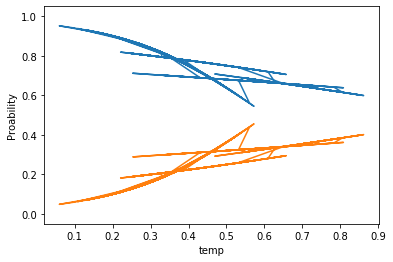

In [125]:
######
# your code here
df = bikes_by_day
df.loc[:,'season_1_temp'] = df['season_1'].values*df.temp.values
df.loc[:,'season_2_temp'] = df['season_2'].values*df.temp.values
df.loc[:,'season_3_temp'] = df['season_3'].values*df.temp.values
df.loc[:,'season_4_temp'] = df['season_4'].values*df.temp.values

data_x = df[['temp','season_1', 'season_2', 'season_3', 'season_4', 'season_1_temp', 'season_2_temp', 'season_3_temp', 'season_4_temp']]

data_y = bikes_by_day['casual_high']

logreg = LogisticRegression(C=100000, fit_intercept=True)
logreg = logreg.fit(data_x, data_y)
logreg.coef_
logreg.intercept_
# dummy_x = np.linspace(np.min(data_x)-10,np.max(data_x)+10)
yhat_logit = logreg.predict_proba(data_x)

plt.plot(data_x['temp'], yhat_logit)
plt.ylim(-0.05,1.05)
plt.ylabel('Proability')
plt.xlabel('temp')


*your answer here*

**6.4  At what temperatures would you classify a day as a high number of casual riders in...**

In [ ]:
######
# your code here
######

**6.5  Fit a logistic regression models to predict `casual_high` from 6 predictors in the dataset....**

In [122]:
######
# your code here
# data_x = bikes_by_day['windspeed','temp','atemp','hum','weekday']
# bikes_by_day = pd.get_dummies(bikes_by_day, columns = ['weekday'], drop_first = False)
bikes_by_day.head

Cs = np.exp(np.arange(-1,5,0.1))
#We already have treated seasons as a categorical variable
data_x = bikes_by_day[['windspeed','temp','atemp','hum','season_1', 'season_2', 'season_3', 'season_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4','weekday_5', 'weekday_6']]
                      
data_y = bikes_by_day['casual_high']
                      
logreg = LogisticRegression(C=Cs, penalty="l2")
logreg = logreg.fit(data_x, data_y.values.reshape(-1,1))
logreg.coef_
logreg.intercept_

######

ValueError: Penalty term must be positive; got (C=array([  0.36787944,   0.40656966,   0.44932896,   0.4965853 ,
         0.54881164,   0.60653066,   0.67032005,   0.74081822,
         0.81873075,   0.90483742,   1.        ,   1.10517092,
         1.22140276,   1.34985881,   1.4918247 ,   1.64872127,
         1.8221188 ,   2.01375271,   2.22554093,   2.45960311,
         2.71828183,   3.00416602,   3.32011692,   3.66929667,
         4.05519997,   4.48168907,   4.95303242,   5.47394739,
         6.04964746,   6.68589444,   7.3890561 ,   8.16616991,
         9.0250135 ,   9.97418245,  11.02317638,  12.18249396,
        13.46373804,  14.87973172,  16.44464677,  18.17414537,
        20.08553692,  22.19795128,  24.5325302 ,  27.11263892,
        29.96410005,  33.11545196,  36.59823444,  40.44730436,
        44.70118449,  49.40244911,  54.59815003,  60.3402876 ,
        66.68633104,  73.6997937 ,  81.45086866,  90.0171313 ,
        99.48431564, 109.94717245, 121.51041752, 134.28977968]))

**6.6 For `['windspeed','temp','atemp','hum']`, plot the estimated coefficient...**

In [ ]:
######
# your code here
######

*your answer here*